In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
import pandas as pd 
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
#import sklearn as sk


#modelos y metricas
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import dump, load
from os.path import exists
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report , f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score

#Xval
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score

#vectorizacion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score

from joblib import dump, load

from os.path import exists
from os import environ

import string

import nltk
from sklearn.pipeline import Pipeline

import sklearn ### ESTA NO SE BORRA ???? #TODO
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from os.path import exists
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

if IN_COLAB == True:
    !pip install nltk

import nltk
nltk.download('stopwords')
stopwords_es = nltk.corpus.stopwords.words('spanish')   
    
import re
from unicodedata import normalize

import tensorflow as tfr

from tensorflow import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, SpatialDropout1D
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, TextVectorization
from keras_preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
import string

#Random forest
from sklearn.ensemble import RandomForestClassifier 

[nltk_data] Downloading package stopwords to /home/fabri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Constantes

In [2]:
# Constantes
SEED=9
JOBS=-2

In [3]:
reviewDfOriginal = pd.read_csv("./review_train.csv")
reviewDf = reviewDfOriginal.copy()

In [4]:
review_pruebasOriginal = pd.read_csv("./review_test.csv")
review_pruebas = review_pruebasOriginal.copy()
review_pruebas

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [5]:
reviewDf = reviewDf.drop(["ID"],  axis='columns', inplace=False)
reviewDf

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...
49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,Voy a tener que estar en desacuerdo con el com...,negativo


### FILTRO REVIEWS EN INGLES

Filtramos y nos quedamos solo con las reviews en epanol para mejorar la efectividad del modelo.
Hay 3 listas hechas a mano debido a que tuvimos que tener cuidado de no incluir palabras cuya raiz exitiera en español, o fueran parte de apellidos ya que en esos casos se veian contenidas (love-lace-, hate-r, excelent-e). Al tener 3 listas con ditintos grupos, fue mas facil armar la lista final. Reconocemos que no es el mejor filtro y que es posible que hayamos eliminado unas pocas reseñas en español y hayan quedado unas pocas en ingles. Sin embargo estamos seguros de que si saca la mayoria de las reseñas en ingles.

In [6]:
lista_palabras_comunes_en = ["have","scary","nothing","issue"]
lista_palabras_positivas_en =["interesting","amusing","intelligent","pretty","beautiful"]
lista_palabras_negativas_en =["boring","bullshit","risk","loss","poor","ugly"]
lista_completa = lista_palabras_comunes_en + lista_palabras_positivas_en + lista_palabras_negativas_en


reviewDf_espanol = reviewDf [~reviewDf["review_es"].str.contains('|'.join(lista_completa))]

reviewDf_espanol

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...
49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,Voy a tener que estar en desacuerdo con el com...,negativo


## Particion

Hacemos la particion  en test y train con el dataset ya filtrado

In [7]:
reviewDf_x = reviewDf_espanol.drop(["sentimiento"],  axis='columns', inplace=False)

reviewDf_y = reviewDf_espanol['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(reviewDf_x,
                                                    reviewDf_y,
                                                    test_size=0.30,
                                                    random_state=SEED,
                                                    shuffle=True
                                                    )

# Bayes Naive

Creamos un modelo Bayes Naives con el proposito de observar el comportamiento general del mismo y generamos una primera predicción 

In [8]:
if not exists('modelos/TP2/naiveBayes-n.joblib'):

    modeloBayesNaive = make_pipeline(TfidfVectorizer(), MultinomialNB())
    modeloBayesNaive.fit(x_train.review_es, y_train)

    dump(modeloBayesNaive, 'modelos/TP2/naiveBayes-n.joblib')

else:
    modeloBayesNaive = load('modelos/TP2/naiveBayes-n.joblib')

prediccion = modeloBayesNaive.predict(x_test.review_es)

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please r

Analizamos las metricas del modelo para ver cual es el desempeño global del mismo, de manera que, se puede tener una referencia del comportamiento general del modelo a la hora de buscar hiperparametros 

              precision    recall  f1-score   support

    negativo       0.85      0.87      0.86      7300
    positivo       0.87      0.84      0.86      7186

    accuracy                           0.86     14486
   macro avg       0.86      0.86      0.86     14486
weighted avg       0.86      0.86      0.86     14486



Text(50.722222222222214, 0.5, 'Verdadero')

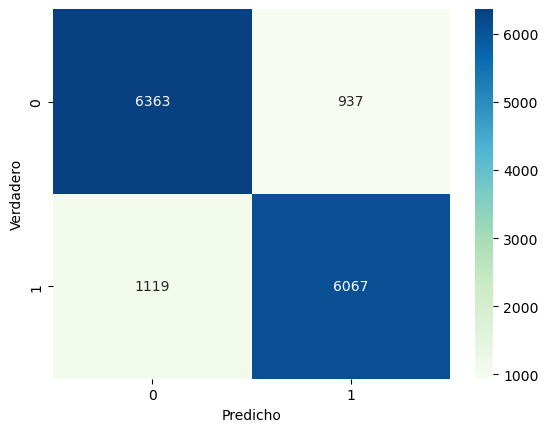

In [9]:
#performance
print(classification_report(y_test,prediccion))

#Creamos la matriz de confusión
tablota=confusion_matrix(y_test, prediccion)

#Grafico la matriz de confusión
sns.heatmap(tablota,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

Generamos una predicción para Kaggle con nuestro primer modelo, el cual tiene un desempeño aceptable 

In [10]:
if not exists('submissions/TP2/naiveBayes-nuevo.csv'):
    prediccionTesteo = modeloBayesNaive.predict(review_pruebas.review_es)
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': prediccionTesteo})
    df_submission.to_csv('submissions/TP2/naiveBayes-nuevo.csv', index=False)

### Busqueda de hiperparametros 

Hacemos un pequeño ajuste sobre los datos de entrada en esta ocación 

In [11]:
y_test_transformed = y_test.map(lambda x: 0 if x == 'positivo' else 1)
y_train_transformed = y_train.map(lambda x: 0 if x == 'positivo' else 1)

Para la busqueda de hiperparametros del modelo bayes naives, se debe considerar realizar en simultaneo la optimización tanto del modelo BN como encontrar las condiciones para que la tecnica TF-IDF, implementada por el TfidfVectorizer, mejore las metricas en el analisis de sentimientos

Por lo tanto realizamos la busqueda de hiperparametros usando valores de prueba para intentar mejorar el modelo y por otro lado valores de prueba para el preprocesamiento del texto 

In [12]:
if not exists('modelos/TP2/nb_hiper.joblib'):
    frecuencia_maxima = [0.9, 0.95, 0.85, 0.98]
    frecuencia_minima = [0.05, 0.07, 0.1, 0.03]
    ngram_range = [(1,1), (1,2), (3,1)]
    alpha = [0.1, 0.5, 1.0, 2.0, 0.8, 0.3, 1.5]
    fit_prior = [True, False]
    class_prior = [None, [0.2, 0.8], [0.5, 0.5]]

    metrica = make_scorer(sklearn.metrics.f1_score)
    folds = 5

    modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])


    parametros = {
        'tfidfvectorizer__stop_words': ['english', stopwords_es, None],
        'tfidfvectorizer__max_df': frecuencia_maxima,
        'tfidfvectorizer__min_df': frecuencia_minima,
        'tfidfvectorizer__ngram_range': ngram_range,
        'multinomialnb__alpha': alpha,
        'multinomialnb__fit_prior': fit_prior,
        'multinomialnb__class_prior': class_prior
    }

    modelo_rcv = RandomizedSearchCV(modelo, parametros, cv=folds, scoring=metrica)
    modelo_rcv.fit(x_train.review_es, y_train_transformed)

    dump(modelo_rcv, 'modelos/TP2/nb_hiper.joblib')
else: 
    modelo_rcv = load('modelos/TP2/nb_hiper.joblib')

In [13]:
modelo_rcv

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   param_distributions={'multinomialnb__alpha': [0.1, 0.5, 1.0,
                                                                 2.0, 0.8, 0.3,
                                                                 1.5],
                                        'multinomialnb__class_prior': [None,
                                                                       [0.2,
                                                                        0.8],
                                                                       [0.5,
                                                                        0.5]],
                                        'multinomialnb__fit_prior': [True,
                                                                     False],
                                        'tfidfvectorizer__max_df': [0.9, 0.95,
                                                                    0.85,
                                                                    0.98],
                                        'tfidfvectorizer__min_df': [0.05, 0.07,
                                                                    0.1, 0.03],
                                        'tfidfvectorizer__ngram_range': [(1, 1),
                                                                         (1, 2),
                                                                         (3,
                                                                          1)],
                                        'tfidfvectorizer__stop_words': ['english',
                                                                        ['de',
                                                                         'la',
                                                                         'que',
                                                                         'el',
                                                                         'en',
                                                                         'y',
                                                                         'a',
                                                                         'los',
                                                                         'del',
                                                                         'se',
                                                                         'las',
                                                                         'por',
                                                                         'un',
                                                                         'para',
                                                                         'con',
                                                                         'no',
                                                                         'una',
                                                                         'su',
                                                                         'al',
                                                                         'lo',
                                                                         'como',
                                                                         'más',
                                                                         'pero',
                                                                         'sus',
                                                                         'le',
                                                                         'ya',
                                                                         'o',
          

Observamos como se comporta el modelo al estudiarlo a detalle usando la tecnica de random search cross validation 

In [14]:
print("F1-Score del modelo: " + str(modelo_rcv.best_score_))
for param, value in modelo_rcv.best_params_.items():
    if param == "tfidfvectorizer__stop_words":
        continue
        
    print(str(param) + ":" + str(value))

F1-Score del modelo: 0.7728904164999303
tfidfvectorizer__ngram_range:(1, 2)
tfidfvectorizer__min_df:0.05
tfidfvectorizer__max_df:0.85
multinomialnb__fit_prior:False
multinomialnb__class_prior:[0.5, 0.5]
multinomialnb__alpha:0.8


Se observa que el modelo tiene un F1-Score bastante parecido a la primera parte del analisis, más sin embargo, el añadido de estos hiperparametros puede ayudar en la simplificación del modelo y mejorar la generalización 

Entrenamos el modelo con los nuevos hiperparametros y realizamos una validacion cruzada para verificar que no haya ningun problema con el modelo seleccionado 

In [15]:
if not exists('modelos/TP2/nb_conhp.joblib'):
    mejores_parametros = modelo_rcv.best_params_

    modelo_final = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer(stop_words=mejores_parametros['tfidfvectorizer__stop_words'],
                                            max_df=mejores_parametros['tfidfvectorizer__max_df'],
                                            min_df=mejores_parametros['tfidfvectorizer__min_df'],
                                             ngram_range=mejores_parametros['tfidfvectorizer__ngram_range'])),
        ('multinomialnb', MultinomialNB(alpha = mejores_parametros['multinomialnb__alpha'],
                                        fit_prior = mejores_parametros['multinomialnb__fit_prior'],
                                        class_prior= mejores_parametros['multinomialnb__class_prior']))
    ])

    modelo_final.fit(x_train.review_es, y_train_transformed)
    dump(modelo_final, 'modelos/TP2/nb_conhp.joblib')
else:
    modelo_final = load('modelos/TP2/nb_conhp.joblib')

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please r

In [16]:
if not exists('modelos/TP2/metricas_nb.joblib'):
    kfoldcv =StratifiedKFold(n_splits=10)
    resultados_nb = cross_validate(modelo_final, x_train.review_es, y_train, cv=kfoldcv,scoring=metrica ,return_estimator=True)
    metricas_nb = resultados_nb['test_score']
    modelo_final = resultados_bb['estimator'][np.where(metricas_nb==max(metricas_nb))[0][0]]
else: 
    metricas_nb = load('modelos/TP2/metricas_nb.joblib')

Text(0.5, 1.0, 'Modelo verificado con 10 folds')

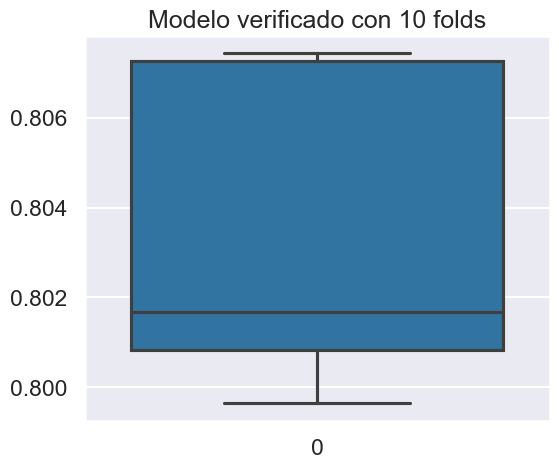

In [17]:
metric_labelsCV = ['F1 Score']*len(metricas_nb)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(6,5))
sns.boxplot(metricas_nb)
plt.title("Modelo verificado con 10 folds")

Observamos que la validación cruzada reatifica el modelo generado y los hiperparametros usados por lo tanto realizamos la prediccion de peso para la competencia de kaggle 




In [18]:
if not exists('submissions/TP2/NMmejorado8.csv'):
    df_submission = pd.DataFrame({'id': review_pruebas['ID'], 'sentimiento': y_pred})
    df_submission['sentimiento'] = df_submission['sentimiento'].map({0: 'positivo', 1: 'negativo'})
    df_submission.to_csv('NMmejorado8.csv', index=False)

# Random Forest

Creamnos el modelo con parametros arbitrarios parta obtener una prediccion inicial. Decidimos fijar los valores de samples_leaf y samples_split y n_estimators por nuestra cuenta ya luuego de varioas pruebas obsevamos que con valores por default (1, 2 y 100 respectictivamente) genera un modelo muy grande que no podremos subir a gitthub y cuya efectividad no mejorara mucho respecto a uno un poco mas chico

In [19]:
if exists('modelos/TP2/modeloRandomForest-sin-optimizar-final.joblib') == False:
    #Creamos un clasificador con hiperparámetros arbitrarios
    
    rfc = RandomForestClassifier(n_jobs=JOBS,
                                 criterion="gini", 
                                 random_state=SEED, 
                                 min_samples_leaf=15,
                                 min_samples_split=40,
                                 n_estimators=40, 
                                 class_weight="balanced")
    
    #rfc = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    
    modeloRandomForest = make_pipeline(TfidfVectorizer(), rfc)

    modeloRandomForest.fit(x_train.review_es, y_train)

    dump(modeloRandomForest, 'modelos/TP2/modeloRandomForest-sin-optimizar-final.joblib')

else:
    modeloRandomForest = load('modelos/TP2/modeloRandomForest-sin-optimizar-final.joblib')

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info

Miramos como fue en test

              precision    recall  f1-score   support

    negativo       0.83      0.83      0.83      7300
    positivo       0.82      0.82      0.82      7186

    accuracy                           0.82     14486
   macro avg       0.82      0.82      0.82     14486
weighted avg       0.82      0.82      0.82     14486



Text(37.08333333333333, 0.5, 'Verdadero')

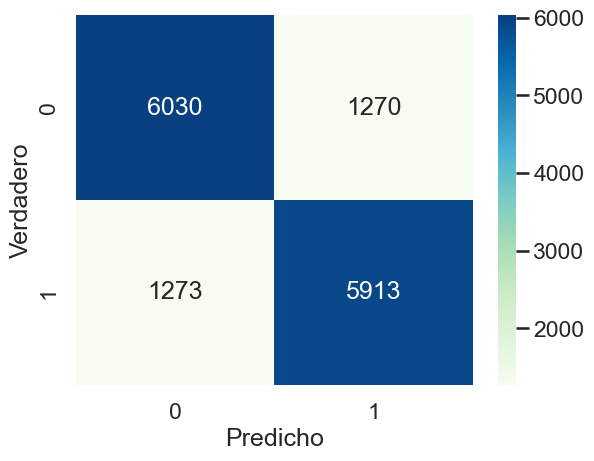

In [20]:
prediccion_rf = modeloRandomForest.predict(x_test.review_es)

#performance
print(classification_report(y_test,prediccion_rf))


#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, prediccion_rf)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')  

Hacemos la submission

In [21]:
if not exists('submissions/TP2/randomForest-sin-opti-final.csv'):
    prediccionTesteo_rf = modeloRandomForest.predict(review_pruebas.review_es)
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': prediccionTesteo_rf})
    df_submission.to_csv('submissions/TP2/randomForest-sin-opti-final.csv', index=False)

#### Optimizacion de hiperparametros con Cros Validation

In [22]:
if exists('modelos/TP2/GsRandomForest_y_tdif-1.joblib') == False:

    gsrf = RandomForestClassifier(class_weight="balanced")


    modeloRandomForest_cv = Pipeline(steps= [ ('tfidfVectorizer', TfidfVectorizer() ), ('gsrf', gsrf) ] )

    param_grid = { "gsrf__criterion" : ["gini", "entropy"], 
                   "gsrf__min_samples_leaf" : [15, 30, 60], #Vamos a hacer muchas combinaciones ya que solo vamos
                   "gsrf__min_samples_split" : [40, 50, 60],#a correr este modelo 1 sola vez; ya que lo vamos a 
                   "gsrf__n_estimators": [40, 50, 80],  #guardar   
                   
                    #Veo si conviene usar stopwords o no.
                   "tfidfVectorizer__stop_words": [None, 'english', stopwords_es], 

                    "tfidfVectorizer__strip_accents": [None, "ascii"],
                    
                    "tfidfVectorizer__min_df": [0.01, 0.08, 0.1],

                    "tfidfVectorizer__max_df" :[ 0.10 , 0.20 , 0.5],

                    "tfidfVectorizer__lowercase" : [True, False],
                    
                   "tfidfVectorizer__analyzer": ["word", "char", "char_wb"],

                    }

    #Probamos entrenando sólo con 1 métrica: f1_scoree

    rf_gs = GridSearchCV(estimator=modeloRandomForest_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=JOBS) #Optimizamos f1_score

    #rf_gs = RandomizedSearchCV (estimator=modeloRandomForest_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=JOBS) #Optimizamos f1_score

    gs_fit = rf_gs.fit(x_train.review_es, y_train)
    
    #guardamos el grid search
    dump(gs_fit, 'modelos/TP2/GsRandomForest_y_tdif-1.joblib')

else:
    gs_fit = load('modelos/TP2/GsRandomForest_y_tdif-1.joblib')

gs_fit.best_params_

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For mor

{'gsrf__criterion': 'gini',
 'gsrf__min_samples_leaf': 15,
 'gsrf__min_samples_split': 40,
 'gsrf__n_estimators': 40,
 'tfidfVectorizer__analyzer': 'word',
 'tfidfVectorizer__lowercase': True,
 'tfidfVectorizer__max_df': 0.1,
 'tfidfVectorizer__min_df': 0.01,
 'tfidfVectorizer__stop_words': None,
 'tfidfVectorizer__strip_accents': None}

Podemos ver que para los hiperparametros del RF, Grid Search recomienda son los mismos que los habiamos usado arbitrariamente. Esto se debe a que, Grid search, en general, tiende a elegir
el numero mas bajo de sample_leafs, samples_split  y n_estimators. Por ello como ya comentamos tomamos como valores mas chicos los usados en el RF sin optimizar para asegurarnos que en la optimizacion de hiperparametros no escoja valores muy pequeños generando un posible overfitting y un modelo muy complejo. <br>
En cuanto a los hiperparametros del vectorizador, recomienda no usar stopwords (las de la lista de la librería NLTK que mandamos como parámetro), no quitar acentos, y usar como analyzer: "word". La principal diferencia es en cuanto al minimo y maximo numero de palabras a tener en cuenta para armar el vocabulario. Recomienda eliminar las palabras que representan menos del 1% del vocabulario y aquellas que representan más del 10% del vocabulario.

In [23]:
#Obtenemos el mejor modelo
mejor_modelo_rf = gs_fit.best_estimator_

#Predicción

prediccion_mejor_modelo_rf = mejor_modelo_rf.predict(x_test.review_es)
prediccion_mejor_modelo_rf

array(['negativo', 'positivo', 'negativo', ..., 'positivo', 'negativo',
       'negativo'], dtype=object)

In [24]:
if not exists ('modelos/TP2/modelo_RandomForest_y_tdif-final.joblib'):
    dump(mejor_modelo_rf, "modelos/TP2/modelo_RandomForest_y_tdif-final.joblib")

Vemos como le va en test

              precision    recall  f1-score   support

    negativo       0.81      0.80      0.81      7300
    positivo       0.80      0.81      0.81      7186

    accuracy                           0.81     14486
   macro avg       0.81      0.81      0.81     14486
weighted avg       0.81      0.81      0.81     14486



Text(37.08333333333333, 0.5, 'Verdadero')

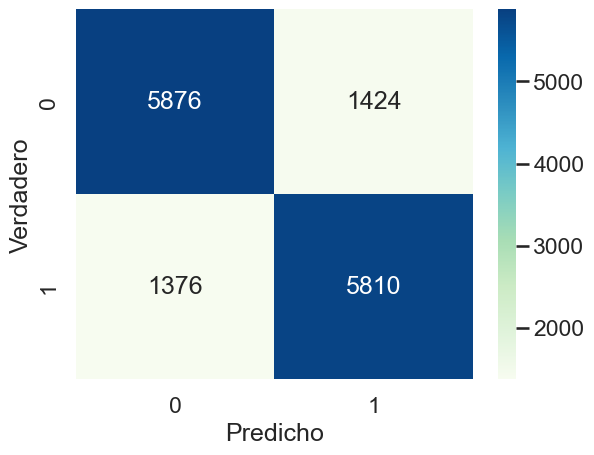

In [25]:
#performance
print(classification_report(y_test,prediccion_mejor_modelo_rf))


#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, prediccion_mejor_modelo_rf)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero') 

Vemos que f1_score disminuyo. En el informe profundizamos en las posibles causa de esto.

### Cross Validation

Hacemos Cross validation con 5 folds

In [26]:
kfoldcv =StratifiedKFold(n_splits=5) 
scorer_fn = make_scorer(sklearn.metrics.f1_score, pos_label='positivo' )

if not exists ('modelos/TP2/resultados_cv_randomForest-final'):
    resultados_rf = cross_validate(mejor_modelo_rf, x_train.review_es, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True, n_jobs = JOBS)
    
    dump(resultados_rf, "modelos/TP2/resultados_cv_randomForest-final")
else:
    resultados_rf = load("modelos/TP2/resultados_cv_randomForest-final")

metricas_cv_rf = resultados_rf['test_score']

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info

Text(0.5, 1.0, 'Modelo entrenado con 5 folds')

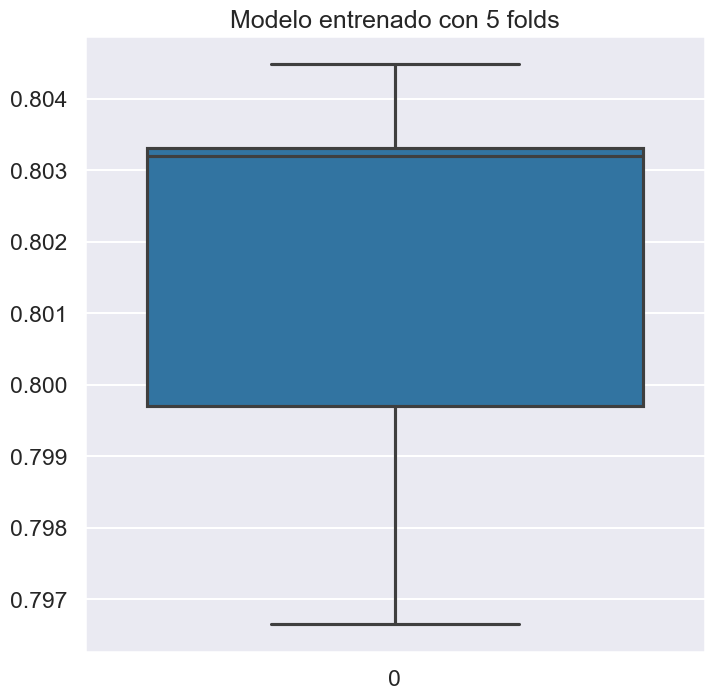

In [27]:
metric_labels_CV_rf = ['F1 Score']*len(metricas_cv_rf) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metricas_cv_rf)
plt.title("Modelo entrenado con 5 folds")

Se puede ver que no hay mucha variacion en los valores obtenidos por lo cual podemos concluir que es un modelo bueno para generalizar.

### Submission Random Forest

In [28]:
if not exists('submissions/TP2/randomForest-y_tdif-final-.csv'):
    prediccionTesteoMejorRf = mejor_modelo_rf.predict(review_pruebas.review_es)
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': prediccionTesteoMejorRf})
    df_submission.to_csv('submissions/TP2/randomForest-y_tdif-final.csv', index=False)

La submission nos dio una disminucion de 4 ptos en Kaggle. Al igual que con las metricas en el ocnjunto de test, en el infomre profundizamos en la posibles razones de esto.

# XGBoost

Realizamos los mismos ajustes hechos para la busqueda de hiperparametros de NB, en este caso, el modelo XGBoost no es capaz de entender las etiquetas positivo/megativo

In [29]:
y_test_transformed = y_test.map(lambda x: 0 if x == 'positivo' else 1)
y_train_transformed = y_train.map(lambda x: 0 if x == 'positivo' else 1)

Generamos un modelo base XGBoost que permitira observar un comportamiento global del modelo a la hora de analizar sentimientos en el texto de las reseñas 

In [30]:
if not exists('modelos/TP2/xgb_base.joblib'):
    xgb_base = make_pipeline(TfidfVectorizer(), XGBClassifier( random_state=0, n_estimators=100))
    xgb_base.fit(x_train.review_es, y_train_transformed)
else:
    xgb_base = load("modelos/TP2/xgb_base.joblib")

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer 

Evaluando nuestro modelo con las metricas que nos interese

In [31]:
y_pred = xgb_base.predict(x_test.review_es)

Verificamos la performance del modelo y observamos su matriz de confusión 

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7186
           1       0.93      0.90      0.91      7300

    accuracy                           0.91     14486
   macro avg       0.91      0.91      0.91     14486
weighted avg       0.91      0.91      0.91     14486



Text(37.08333333333333, 0.5, 'Verdadero')

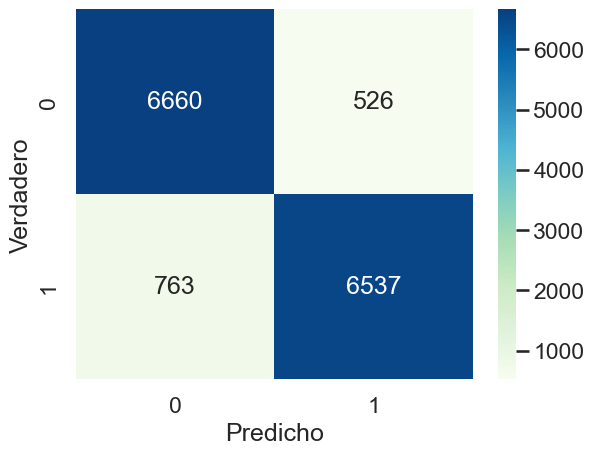

In [32]:
#performance
print(classification_report(y_test_transformed,y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test_transformed, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

Observamos que el modelo tiene un buen desempeño a la hora de

Generamos una primera predicción para kaggle

In [33]:
if not exists('submissions/TP2/xgboost_base.csv'):
    pred = xgb_base.predict(review_pruebas.review_es)
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': pred})
    df_submission['sentimiento'] = df_submission['sentimiento'].map({0: 'positivo', 1: 'negativo'})
    df_submission.to_csv('submissions/TP2/xgboost_base.csv', index=False)

### Busqueda de hiperparametros del XGBoost 

En un intento de mejorar las metricas de prediccion del modelo, como tambien de simplificarlo y generar un modelo más simple con una capacidad de prediccion similar realizamos la busqueda de hiperparamtros del xgboost utilizando parametros conocidos, como también, modificando hiperparametros en el preprocesamiento del texto para mejorar el analisis de sentimientos y ajustar le posible overfit 

In [34]:

if not exists('modelos/TP2/hipers_xgb.joblib'):
    
    estimadores = [90, 100, 110, 150]
    frecuencia_maxima = [0.9, 0.95, 0.98]
    frecuencia_minima = [0.05, 0.07, 0.03]
    profundidad_max = [7, 8, 9, 10, 15]
    learning_rate = [0.01, 0.05, 0.1, 0.2]
    metrica = make_scorer(sklearn.metrics.f1_score)
    folds = 5

    parametros = {
    'tfidfvectorizer__stop_words': ['english', stopwords_es],
    'tfidfvectorizer__max_df': frecuencia_maxima,
    'tfidfvectorizer__min_df': frecuencia_minima,
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'xgbclassifier__n_estimators': estimadores,
    'xgbclassifier__max_depth': profundidad_max,
    'xgbclassifier__learning_rate': learning_rate,
}

    modelo = make_pipeline(TfidfVectorizer(), XGBClassifier())

    modelo_rcv = RandomizedSearchCV(modelo, parametros, cv=folds, scoring = metrica)
    modelo_rcv.fit(x_train.review_es, y_train)
    dump(modelo_rcv, 'modelos/TP2/hipers_xgb.joblib')
else: 
    metrica = make_scorer(sklearn.metrics.f1_score)
    modelo_rcv = load('modelos/TP2/hipers_xgb.joblib')

/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer 

In [35]:
# print("F1-Score del modelo: " + modelo_rcv.best_score_)
# print("Hiperparametros del modelo con mejor F1-Score:" + modelo_rcv.best_params_)

Entrenamos un nuevo modelo usando los hiperparametros encontrados en la busqueda anterior 

In [36]:
if not exists('modelos/TP2/xgb_tuneado.joblib'):
    mejores_parametros = modelo_rcv.best_params_

    modelo_final = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words=mejores_parametros['tfidfvectorizer__stop_words'],
                                                                   max_df=mejores_parametros['tfidfvectorizer__max_df'],
                                                                   min_df=mejores_parametros['tfidfvectorizer__min_df'],
                                                                   ngram_range=mejores_parametros['tfidfvectorizer__ngram_range'])),
                                   ('xgbclassifier', XGBClassifier(n_estimators=mejores_parametros['xgbclassifier__n_estimators'],
                                                                  max_depth=mejores_parametros['xgbclassifier__max_depth'],
                                                                  learning_rate=mejores_parametros['xgbclassifier__learning_rate']))])

    modelo_final.fit(x_train.review_es, y_train_transformed)
else:
    xgb_tuneado = load('modelos/TP2/xgb_tuneado.joblib')

Realizo validacion cruzada del modelo para observar su comportamiento *nota* TARDA MUCHISIMO

In [37]:
if not exists('modelos/TP2/xgb_metricas.joblib'):
    kfoldcv =StratifiedKFold(n_splits=10)
    resultados_xgb = cross_validate(xgb_tuneado, x_train.review_es, 
                                    y_train_transformed, cv=kfoldcv,
                                    scoring=metrica ,return_estimator=True)
    metricas_xgb = resultados_xgb['test_score']
    dump(metricas_xgb, 'modelos/TP2/xgb_metricas.joblib')
    xgb_tuneado = resultados_xgb['estimator'][np.where(metricas_xgb==max(metricas_xgb))[0][0]]
else: 
    metricas_xgb = load('modelos/TP2/xgb_metricas.joblib')


Text(0.5, 1.0, 'Modelo entrenado con 10 folds')

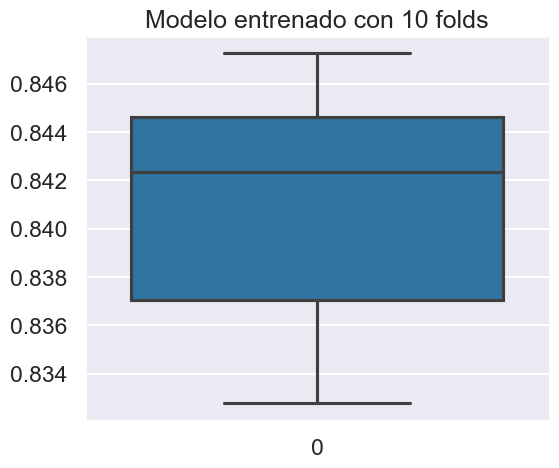

In [38]:
metric_labelsCV = ['F1 Score']*len(metricas_xgb)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(6,5))
sns.boxplot(metricas_xgb)
plt.title("Modelo entrenado con 10 folds")

Notas sobre XGBoost

El XGBoost más efectivo con un score en kaggle de 0.72 fue generando usando unicamente el conjunto de hiperparametros correspondiente al XGboost y tan solo modificando las stopwords en el procesamiento del texto, sin embargo, se realizo multiples pruebas con multiples hiperparametros y esas busquedas son las reflejadas en el analisis 

# Red Neuronal

## Pre tokenizacion
Antes de tokenizar las reviews, vamos a hacer una pequena limpieza adicional.


In [39]:
if not exists('reviews_filtradas.csv'):
    frasesFiltradas = []
    for index, value in reviewDf_espanol["review_es"].items():
        #Ponemos todas las palabras en lowercase
        value = value.lower()

        #Saco las stopwords
        valueFiltrado = [x for x in value.split() if x not in stopwords_es]
        #Vuelvo a unir el texto
        valueFiltrado = " ".join(valueFiltrado)

        #Saca los diacriticos de letras como vocales, etc (la ñ se mantiene)
        #Expresion regular obtenida de: https://es.stackoverflow.com/a/139811
        valueFiltrado = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
                                normalize( "NFD", valueFiltrado), 0, re.I)
        valueFiltrado = normalize( 'NFC', valueFiltrado)

        #Saco los signos de puntuacion
        #Funcion obtenida de: https://stackoverflow.com/a/266162/13683575
        valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', string.punctuation))
        valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¡'))
        valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¿'))
        
        #Anadimos la frase a la lista de frases filtradas
        frasesFiltradas.append(valueFiltrado)
    reviewDfFiltrado = pd.DataFrame(data={'review_es':frasesFiltradas, 'sentimiento':reviewDf_espanol['sentimiento']})
    reviewDfFiltrado.to_csv('reviews_filtradas.csv', index=False)

else:
    reviewDfFiltrado = pd.read_csv("./reviews_filtradas.csv")

In [40]:
reviewDfFiltrado

,review_es,sentimiento
0,criticos mencionado despues ver solo 1 oz epis...,positivo
1,pequeña pequeña produccionla tecnica filmacion...,positivo
2,pense manera maravillosa pasar tiempo fin sema...,positivo
3,basicamente familia niño pequeño jake piensa z...,negativo
4,amor tiempo petter mattei pelicula visualmente...,positivo
...,...,...
48279,pense pelicula hizo buen trabajo derechano tan...,positivo
48280,mala parcela mal dialogo mala actuacion direcc...,negativo
48281,catolica enseñada escuelas primarias parroquia...,negativo
48282,voy tener desacuerdo comentario anterior lado ...,negativo


## Creacion de los sets de entrenamiento

Transformamos la columna objetivo de "positivo" y "negativo" a 0 y 1 para poder usarlos en la red neuronal

In [41]:
y = reviewDfFiltrado['sentimiento']
y = np.array(list(map(lambda x: 1 if x=="positivo" else 0, y)))
y

array([1, 1, 1, ..., 0, 0, 0])

Creamos set de train y test

In [42]:
x_train, x_test, y_train, y_test = train_test_split(reviewDfFiltrado["review_es"],
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=SEED) #Semilla 9, como el Equipo !!

Creamos el vocabulario en base a nuestro set de train. Las palabras van a estar ordenadas por su frecuencia

In [43]:
vocabulary = Counter()
for fila in x_train:
    fila = fila.split()
    for i in range(0, len(fila)):
        fila[i] = bytes(fila[i], 'utf-8')
    vocabulary.update(list(fila))


Vamos a ver si el vocabulario se genero correctamente

In [44]:
vocabulary.most_common()[1:5]

[(b'si', 24964), (b'solo', 19583), (b'peliculas', 19506), (b'ser', 18017)]

Vemos que la palabra mas frecuente es "pelicula", cosa que hace sentido.

Si no hubiesemos hecho el proceso de remocion de stopwords, es probable que la palabra mas frecuente seria una preposicion

Para reducir el tamaño del vocabulario, vamos a quedarnos solamente con las 10000 palabras mas frecuentes.

In [45]:
vocab_size = 10000
truncated_vocabulary = [
word for word, count in vocabulary.most_common()[:vocab_size]]

Vamos a crear una tabla que asocia cada palabra del diccionario con su coordena (la cual representa su frecuencia en el dataset de entrenamiento)

In [46]:
table = {}
for i in range(0, len(truncated_vocabulary)):
    table[truncated_vocabulary[i]] = i

In [47]:
table

{b'pelicula': 0,
 b'si': 1,
 b'solo': 2,
 b'peliculas': 3,
 b'ser': 4,
 b'historia': 5,
 b'tan': 6,
 b'ver': 7,
 b'realmente': 8,
 b'vez': 9,
 b'mejor': 10,
 b'bien': 11,
 b'gran': 12,
 b'puede': 13,
 b'hace': 14,
 b'tiempo': 15,
 b'despues': 16,
 b'hecho': 17,
 b'a\xc3\xb1os': 18,
 b'personajes': 19,
 b'personas': 20,
 b'vida': 21,
 b'final': 22,
 b'incluso': 23,
 b'dos': 24,
 b'parte': 25,
 b'y': 26,
 b'como': 27,
 b'bastante': 28,
 b'visto': 29,
 b'asi': 30,
 b'hacer': 31,
 b'que': 32,
 b'nunca': 33,
 b'podria': 34,
 b'lugar': 35,
 b'menos': 36,
 b'simplemente': 37,
 b'haber': 38,
 b'embargo': 39,
 b'actuacion': 40,
 b'tipo': 41,
 b'parece': 42,
 b'escena': 43,
 b'buena': 44,
 b'bueno': 45,
 b'hombre': 46,
 b'aqui': 47,
 b'aunque': 48,
 b'decir': 49,
 b'escenas': 50,
 b'manera': 51,
 b'sido': 52,
 b'mientras': 53,
 b'trabajo': 54,
 b'cada': 55,
 b'cualquier': 56,
 b'el': 57,
 b'cosas': 58,
 b'demasiado': 59,
 b'hizo': 60,
 b'actores': 61,
 b'creo': 62,
 b'personaje': 63,
 b'primera'

## Tokenizacion de las reviews

Pasamos de la representacion en texto de la reviews a una version tokenizada. Vamos a usar los ids de la tabla para lograrlo

Todas tienen que tener la misma longitud, asique decidimos que todas tengan 300 palabras como maximo. 

Si faltan palabras o sobran, le ponemos el valor 10001 (para indicar que esta fuera de nuestro vocabulario)

In [48]:
def pasarDePalabraANumero(conjuntosDePalabras, cantMaxPalabras=300):
    listaDeNumeros = []
    i=0
    for fila in conjuntosDePalabras:
        fila = fila.split()
        fila = fila[:300]
        tokenDeFrase = []
        
        for word in fila:
            tokenDeFrase.append(int(table.get(bytes(word, 'utf-8'),10001)))
            
        while len(tokenDeFrase) < 300:
            tokenDeFrase.append(10001)
            
        listaDeNumeros.append(np.array(tokenDeFrase))
        i+=1
    return listaDeNumeros

In [49]:
numerico = pasarDePalabraANumero(x_train)
numericoTest = pasarDePalabraANumero(x_test)
numericoSubmit =  pasarDePalabraANumero(review_pruebas['review_es'])

Ejemplo de como se ven:

In [50]:
numerico[66]

array([ 1502, 10001,    22,  6540,   851,     0,  1111,  2178,    94,
         273, 10001,   859,    89,   622,  3346,  2786,  2115,  3613,
          27,  1438,     0,    66,  3470,    18,    16,   187,    67,
        3613,    27,     3,   622, 10001,   404,   273,  2049,  3240,
          68, 10001, 10001, 10001,   172, 10001, 10001,   478, 10001,
         184,    85,   178,  2123,   635,   622, 10001,   927, 10001,
         346,   440,   384,  5007,   314,   927, 10001,   820,     0,
         107,   312,   927, 10001, 10001,    28,   250,   404,   273,
         312,   927, 10001,    50, 10001,   580,    28,  3796,   634,
        7176,  1181,   201,  1334,   927, 10001,   565, 10001,   119,
         761,   801,  2598,    38,   669,   312,   254,   314,     0,
          16,    63, 10001,  2883,  1682,  6112,     0, 10001, 10001,
        3687,    22,  4457, 10001,   793,    93,  1465,   149, 10001,
        6283,   644,   386,    12,   111,   588,   689,   147,    71,
         737,    49,

In [51]:
data_list = np.stack(numerico)
data_list_test = np.stack(numericoTest)
data_list_submit = np.stack(numericoSubmit)

## Creacion de la red (sin hiperparametros)

Vamos a usar la layer intermedia "GRU", siguiendo la guia del libro de la bibiliografia. Esta tiene comportamiento muy similar a la LSTM (las cuales son optimas para el analisis de sentimiento)

In [52]:
embed_size = 128
redNeuronal = keras.models.Sequential([
    
keras.layers.Embedding(len(table), embed_size,
        input_shape=[None]),
    
    keras.layers.GRU(128, return_sequences=True),
    
    keras.layers.GRU(128),
    
    keras.layers.Dense(1, activation="sigmoid")
])
redNeuronal.compile(loss="binary_crossentropy", optimizer="adam",
            metrics=["accuracy"])

In [53]:
redNeuronal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,478,273
Trainable params: 1,478,273
Non-trainable params: 0
_________________________________________________________________


In [54]:
if exists('modelos/TP2/redNeuronalSentimiento2.joblib') == False:
    historia_modelo=redNeuronal.fit(x = data_list, 
                                    y = y_train, epochs=4)
    dump(redNeuronal, 'modelos/TP2/redNeuronalSentimiento2.joblib')
else:
    redNeuronal = load('modelos/TP2/redNeuronalSentimiento2.joblib')

In [55]:
if exists('modelos/TP2/predTestRedSinOptimi.joblib') == False:
    y_pred = redNeuronal.predict(data_list_test)
    y_predCerteza = np.where(y_pred>0.7,1,0)
    dump(y_predCerteza, 'modelos/TP2/predTestRedSinOptimi.joblib')
else:
    y_predCerteza = load('modelos/TP2/predTestRedSinOptimi.joblib')
y_predCerteza

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

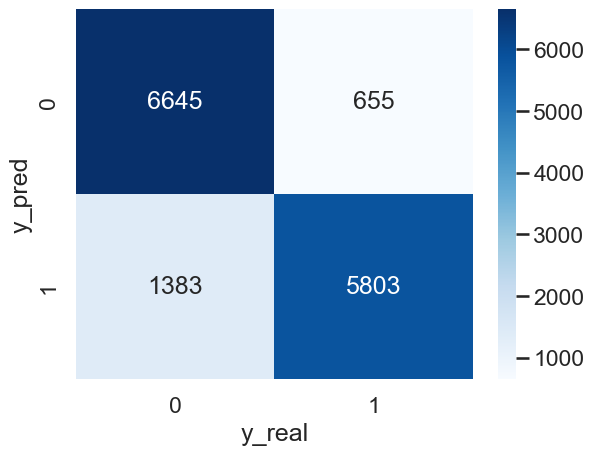

In [56]:
ds_validacion=pd.DataFrame(y_predCerteza,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues', fmt='g')
plt.show()

In [57]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_predCerteza)
recall=recall_score(y_test,y_predCerteza)
f1=f1_score(y_test,y_predCerteza,)
precision=precision_score(y_test,y_predCerteza)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8593124395968521
Recall: 0.8075424436404119
Precision: 0.8985754103437597
f1 score: 0.8506303136909996


In [58]:
if not exists('submissions/TP2/redesNeuronales2.csv'):
    yEnEspanol =y_predCerteza
    yEnEspanol = np.array(list(map(lambda x: "positivo" if x==1 else "negativo", y_predCerteza)))
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': yEnEspanol})
    df_submission.to_csv('submissions/TP2/redesNeuronales2.csv', index=False)

## Busqueda de hiperparametros

Vamos a realizar la busqueda de hiperparametros:

In [59]:
loss='binary_crossentropy'
metrics=['accuracy']
optimizer="adam"

def creador_modelo(learning_rate = 0.1, 
                   activation = 'sigmoid', 
                   output = 2, 
                  hidden_layers = 2
                  ):
    modeloHiper = keras.Sequential()
    
    modeloHiper.add(keras.layers.Embedding(len(table), embed_size,
        input_shape=[None]))
    
    modeloHiper.add(keras.layers.GRU(128, return_sequences=True))
    modeloHiper.add(keras.layers.GRU(128))
    
    for i in range(hidden_layers):
        modeloHiper.add(keras.layers.Dense(output, activation=activation))

    modeloHiper.add(keras.layers.Dense(1, activation="sigmoid"))
    
    modeloHiper.compile(
      optimizer=optimizer,
      loss=loss, 
      metrics=metrics, 
    )
    return modeloHiper


In [60]:
model = KerasClassifier(build_fn=creador_modelo, 
                        verbose=1)

/tmp/ipykernel_10685/2109703127.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=creador_modelo,


In [61]:
param_grid = { 
                  "hidden_layers" : [1, 5, 10, 15, 20], 
                    "output" : [1, 2, 4, 8, 32, 64], 
                    "batch_size" : [5, 10, 20],
                    "epochs" : [5, 10, 15],
                   "activation": ["sigmoid", "relu", "softmax", "softplus", "elu", ]
             } 

Vamos a realizar 5 random searches para buscar los mejores hiperparametros para la red

In [62]:
rs = RandomizedSearchCV(estimator=model, 
                        param_distributions=param_grid,
                        n_jobs=JOBS, cv=3,
                        n_iter=8)

In [63]:
if exists('modelos/TP2/rs_redNeuronal.joblib') == False:
    rs_redNeuronal=rs.fit(X = data_list, 
                            y = y_train)

    dump(rs_redNeuronal, 'modelos/TP2/rs_redNeuronal.joblib')
else:
    rs_redNeuronal = load('modelos/TP2/rs_redNeuronal.joblib')

In [64]:
rs_redNeuronal.best_params_

{'output': 4,
 'hidden_layers': 1,
 'epochs': 10,
 'batch_size': 5,
 'activation': 'softplus'}

## Creamos la red con los hiperparametros encontrados arriba

In [65]:
embed_size = 128
modeloHiper = keras.models.Sequential()
    
modeloHiper.add(keras.layers.Embedding(len(table), embed_size,
        input_shape=[None]))
    
modeloHiper.add(keras.layers.GRU(128, return_sequences=True))
    
modeloHiper.add(keras.layers.GRU(128))
    
for i in range(rs_redNeuronal.best_params_['hidden_layers']):
    modeloHiper.add(keras.layers.Dense(rs_redNeuronal.best_params_['output'],
                                       activation=rs_redNeuronal.best_params_['activation']))
    
modeloHiper.add(keras.layers.Dense(1, activation="sigmoid"))

modeloHiper.compile(loss="binary_crossentropy", optimizer="adam",
            metrics=["accuracy"])

In [66]:
if exists('modelos/TP2/redNeuronalHiper.joblib') == False:
    historia_modelo=modeloHiper.fit(x = data_list, 
                                    y = y_train, epochs=rs_redNeuronal.best_params_['epochs'])

    dump(modeloHiper, 'modelos/TP2/redNeuronalHiper.joblib')

else:
    modeloHiper = load('modelos/TP2/redNeuronalHiper.joblib')


In [67]:
if exists('modelos/TP2/predTestRedConOptimi.joblib') == False:
    y_pred = modeloHiper.predict(data_list_test)
    y_pred
    y_predCerteza = np.where(y_pred>0.7,1,0)
    y_predCerteza
    dump(y_predCerteza, 'modelos/TP2/predTestRedConOptimi.joblib')
else:
    y_predCerteza = load('modelos/TP2/predTestRedConOptimi.joblib')
y_predCerteza

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

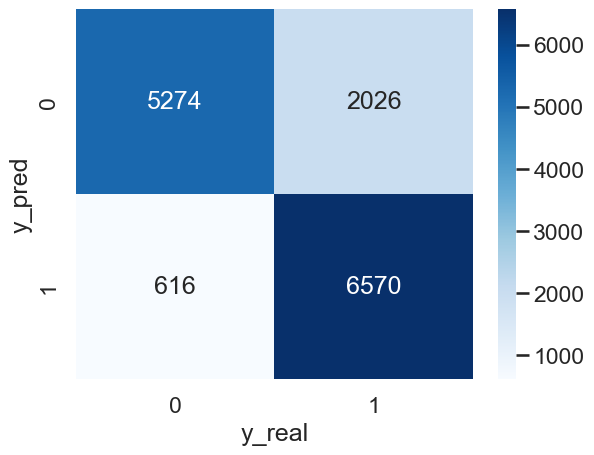

In [68]:
ds_validacion=pd.DataFrame(y_predCerteza,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues', fmt='g')
plt.show()

In [69]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_predCerteza)
recall=recall_score(y_test,y_predCerteza)
f1=f1_score(y_test,y_predCerteza,)
precision=precision_score(y_test,y_predCerteza)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8176170095264393
Recall: 0.9142777623156136
Precision: 0.7643089809213588
f1 score: 0.8325940945380813


### Prediccion al set de datos de test

In [70]:
if exists('modelos/TP2/predTestRedConOptimi.joblib') == False:
    y_pred = modeloHiper.predict(data_list_submit)
    y_predCerteza = np.where(y_pred>0.7,1,0)
    dump(y_predCerteza, 'modelos/TP2/predTestRedConOptimi.joblib')
else:
    y_predCerteza = load('modelos/TP2/predTestRedConOptimi.joblib')
y_predCerteza

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [71]:
if not exists('submissions/TP2/redesNeuronales3.csv'):
    yEnEspanol =y_predCerteza
    yEnEspanol = np.array(list(map(lambda x: "positivo" if x==1 else "negativo", y_predCerteza)))
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': yEnEspanol})
    df_submission.to_csv('submissions/TP2/redesNeuronales3.csv', index=False)

# Ensamble de 3 modelos

Armamos un ensamble sencillo de tipo voting con los modelos bases generados a lo largo del analisis.

La utilización de los modelos bases se debe a que utilizamos varios predictores debiles con el proposito de construir uno que en conjunto funcione mejor y asi aprovechar tambien los modelos diseñados previamente 

In [72]:
if not exists('modelos/TP2/voting.joblib.gz'): #Tenemos el archivo comprimido porque era muy grande
    naives = load("modelos/TP2/nb_conhp.joblib")
    xgb = load("modelos/TP2/xgb_base.joblib")
    rf = load("modelos/TP2/modeloRandomForest-sin-optimizar-final.joblib")

    ensamble = VotingClassifier(estimators = [
        ('nb', naives),
        ('xgb', xgb),
        ('rf', rf)
    ])
    ensamble.fit(x_train, y_train)
    dump(ensamble, 'modelos/TP2/voting.joblib')
    !gzip modelos/TP2/voting.joblib #Comprimimos

else:
    !gzip -d -k modelos/TP2/voting.joblib.gz #Descomprimimos
    ensamble = load('modelos/TP2/voting.joblib')
    !rm modelos/TP2/voting.joblib
    

Entrenamos el modelo 

In [73]:
ensamble

VotingClassifier(estimators=[('nb',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(max_df=0.9,
                                                               min_df=0.03,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('multinomialnb',
                                               MultinomialNB(alpha=0.3))])),
                             ('xgb',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer()),
                                              ('xgbclassifier',
                                               XGBClassifier(base_score=0.5,
                                                             booster='gbtree',
                                                             callbacks=None,
                                                             colsample_bylev...
                                                             monotone_constraints='()',
                                                             n_estimators=100,
                                                             n_jobs=0,
                                                             num_parallel_tree=1,
                                                             predictor='auto',
                                                             random_state=0,
                                                             reg_alpha=0,
                                                             reg_lambda=1, ...))])),
                             ('rf',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      min_samples_leaf=15,
                                                                      min_samples_split=40,
                                                                      n_estimators=40,
                                                                      n_jobs=-2,
                                                                      random_state=9))]))])

Sobre el ensamble realizamos una validacion cruzada para comprobar que su metricas al estar asociadas a las metricas individuales de los modelos siguie siendo optima 

In [74]:
kfoldcv = StratifiedKFold(n_splits=5) 
scorer_fn = make_scorer(sklearn.metrics.f1_score)

if not exists ('modelos/TP2/ensambleCrossvalidation.joblib.gz.part-aa'):
    resultados_rf = cross_validate(ensamble, x_train, 
                                   y_train, cv=kfoldcv,
                                   scoring=scorer_fn,
                                   return_estimator=True, n_jobs = JOBS)
    
    dump(resultados_rf, "modelos/TP2/ensambleCrossvalidation.joblib")
    #Comprimimos el archivo
    !gzip -v -9 modelos/TP2/ensambleCrossvalidation.joblib
    #Separamos en varios archivos para que github no nos haga drama. #GithubDestruidoConElPoderDeUnix
    !split -b 50m modelos/TP2/ensambleCrossvalidation.joblib.gz modelos/TP2/ensambleCrossvalidation.joblib.gz.part-
    !rm modelos/TP2/ensambleCrossvalidation.joblib.gz

else:
    #Reconstruimos el zip
    !cat modelos/TP2/ensambleCrossvalidation.joblib.gz.part-a* > modelos/TP2/ensambleCrossvalidation.joblib.gz
    #Descomprimimos
    !gzip -d -k modelos/TP2/ensambleCrossvalidation.joblib.gz
    resultados_rf = load('modelos/TP2/ensambleCrossvalidation.joblib')
    !rm modelos/TP2/ensambleCrossvalidation.joblib
    !rm modelos/TP2/ensambleCrossvalidation.joblib.gz


metricas_cv_rf = resultados_rf['test_score']

In [75]:
metricas_cv_rf

array([0.83010753, 0.83674358, 0.83285303, 0.83278026, 0.83367556])

Text(0.5, 1.0, 'Modelo entrenado con 5 folds')

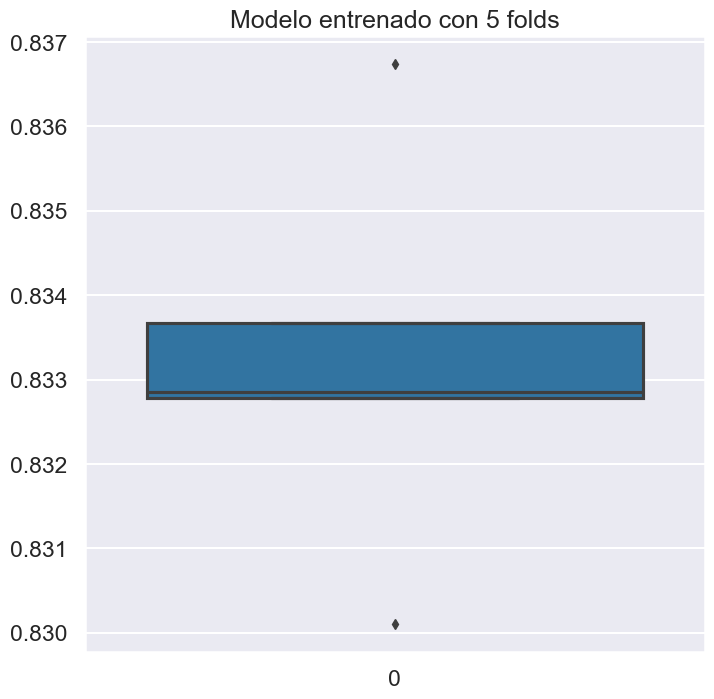

In [76]:
metric_labels_CV_rf = ['F1 Score']*len(metricas_cv_rf) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metricas_cv_rf)
plt.title("Modelo entrenado con 5 folds")

## Hacemos prediccion sobre el set de testeo

In [77]:
if not exists('submissions/TP2/ensamble.csv'):
    pred = ensamble.predict(review_pruebas.review_es)
    df_submission = pd.DataFrame({'id': review_pruebasOriginal['ID'], 'sentimiento': pred})
    df_submission['sentimiento'] = df_submission['sentimiento'].map({1: 'positivo', 0: 'negativo'})
    df_submission.to_csv('submissions/TP2/ensamble.csv', index=False)

Nota sobre el ensamble hibrido: 

El modelo de mejor performance en kaggle que elevo la posicion del equipo es un modelo incompleto puesto que esta armado unicamente con dos modelos, pero, el modelo expuesto en esta porción del analisis incluye los dos modelos usados en el armado del ensamble que genero la mejor predicción

De manera conclusiva es importante destacar que los ensambles son los modelos que mejor encaran la predicción en el analisis de sentimientos de las reviews de peliculas 